In [14]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, random, uniform
import scipy.stats
from dataclasses import dataclass
from numpy.linalg import norm
import math
import copy
import time


Настройки фильтра

In [15]:
#Размер поля
size_x = 10
size_y = 10
#Точки, относительно которых проводятся измерения
points = np.array([(0.2 * size_x, 0.2 * size_y), 
            (0.8 * size_x, 0.8 * size_y), 
            (0.2 * size_x, 0.8 * size_y), (0.8 * size_x, 0.2 * size_y)])
#Шумы
noize_dist = 0.2
noize_rot = 0.2
noize_sens = 0.2
#Настройка отвечает за то, какой метод передвижения используется: с поворотом или без
bot_rotation = True
#Число итераций
iterations = 12
#Число частиц
N_p = 1000

Построение и отрисовка Би-сплайнов

In [16]:
def numerical_interpolate(t, degree, points : np.array):
    i = s = l = 0
    n = len(points)

    assert degree > 1
    assert degree < (n-1)

    #generate knot vector
    knots = [0]*(p+1) + [(i)/(n - degree) for i in range(1, n - p)] + [1]*(p+1)
    
    assert len(knots) == n + degree + 1
    
    domain = [degree, len(knots) - 1 - degree]
    
    for i in range(domain[0], domain[1]):
        if (t>=knots[i] and t <= knots[i+1]):
            s = i
            break
            
    v = copy.deepcopy(points)
        
    alpha = 0
    for l in range(1, degree + 2):
        for i in range(s, s-degree-1+l, -1):
            alpha = (t - knots[i]) / (knots[i+degree+1-l] - knots[i])
            v[i] = (1 - alpha) * v[i-1] + alpha * v[i]
    
    return v[s]


def create_curve(p, points, n=10000):
    ts = np.linspace(0, 1, n)
    curve = np.array([numerical_interpolate(t, p, points) for t in ts])
    return curve

def plot_curve(curve, points):
    points = np.array(points)
    curve = np.array(curve)
    plt.scatter(points[:,0], points[:,1], c='g')
    plt.plot(curve[:,0], curve[:,1])
    plt.show()


def generate_points(n):
    return np.array([np.array([i, math.cos(i)]) for i in range(n)])


    

In [17]:
def angle(a, b):
    if b[0] - a[0] != 0:
        return np.arctan(b[1] - a[1])/(b[0] - a[0])
    else:
        return np.pi/2

In [18]:
def dist(a, b):
    return ((b[1]-a[1])**2 + (b[0] - a[0])**2)**.5

In [19]:
class Robot():
    def __init__(self, x, y, rot):
        self.x = x
        self.y = y
        self.rotation = rot
    
    def move(self, movement):
        
        self.rotation += movement[1] + randn(self.N) * noize_rot
        self.rotation %= 2 * np.pi

        self.x += np.cos(self.rotation) * movement[0]
        self.y += np.sin(self.rotation) * movement[0]
        self.rotation += movement[2]
    
    def plot(self):
        pass
    
    def move_on_curve(self, curve, index):
        self.x = curve[index][0]
        self.y = curve[index][1]
        self.rotation = angle(curve[index], curve[index + 1])
    
    def get_dist_to_points(self):
        return (norm(points - np.array([self.x, self.y]), axis=1) + (randn(len(points)) * noize_sens))

In [20]:
@dataclass
class Particle():
    x: float
    y: float
    rotation: float
    weight: float

Фильтр частиц

In [21]:
class ParticleFilter():

    def __init__(self, N, x_lim, y_lim):
        self.particles = []
        self.N = N
        self.x_lim = x_lim
        self.y_lim = y_lim
        for i in range(N):
            self.particles.append(Particle(uniform(0, x_lim), uniform(0, y_lim), uniform(0, 2*np.pi), 1/N))
    def get_coords(self):
        res = np.empty((self.N, 2))
        for i in range(self.N):
            res[i][0] = self.particles[i].x
            res[i][1] = self.particles[i].y
        return res
    def get_weights(self):
        res = np.empty(self.N)
        for i in range(self.N):
            res[i] = self.particles[i].weight
        return res
    def get_particles(self):
        res = np.empty((self.N, 3))
        for i in range(self.N):
            res[i][0] = self.particles[i].x
            res[i][1] = self.particles[i].y
            res[i][2] = self.particles[i].rotation
        return res
    def set_particles(self, new_particles):
        for i in range(self.N):
            self.particles[i] = Particle(new_particles[i][0], new_particles[i][1], uniform(0, 2*np.pi), 1/self.N)
    
    def predict(self, u):
        for i in range(self.N):
            self.particles[i].x += u[0] + randn()*noize_dist
            self.particles[i].y += u[1] + randn()*noize_dist
    def predict1(self, u):
        
        for i in range(self.N):
            dist = u[0] + randn()*noize_dist
            #Изменение угла поворота чатиц
            self.particles[i].rotation += u[1] + randn()*noize_rot
            self.particles[i].rotation %= 2 * np.pi
            #Изменение координат чатсиц
            self.particles[i].x += np.cos(self.particles[i].rotation) * dist
            self.particles[i].y += np.sin(self.particles[i].rotation) * dist
    def weight(self, norm):
        sum_weight = 0
        for i, point in enumerate(points):
            distance = np.linalg.norm(self.get_coords() - point, axis=1)
            for j in range(self.N):
                self.particles[j].weight *= scipy.stats.norm(distance, noize_sens).pdf(norm[i])[j]
        for i in range(self.N):
            self.particles[i].weight += 1.e-12
            sum_weight += self.particles[i].weight
        for i in range(self.N):
            self.particles[i].weight/=sum_weight
    def neff(self):
        res = 0
        for i in range(self.N):
            res += self.particles[i].weight**.5
        return 1. / res
    
    def resample(self):
        if self.neff() < self.N/2:
            positions = (random() + np.arange(self.N)) / self.N
            cumulative_sum = [0]
            summ = 0
            for i in range(self.N):
                summ += self.particles[i].weight
                cumulative_sum.append(summ)
            i, j = 0, 0
            indexes = np.zeros(self.N, 'i')
            while i < self.N:
                if positions[i] < cumulative_sum[j]:
                    indexes[i] = j
                    i += 1
                else:
                    j += 1
            new_particles = np.empty((self.N, 3))
            old_particles = self.get_particles()
            for i in range(self.N):
                new_particles[i] = old_particles[indexes[i] - 1]
            self.set_particles(new_particles)
            
    def estimate(self):
        pos = self.get_coords()
        weight = self.get_weights()
        mean = np.average(pos, weights=weight, axis=0)
        return mean

def plot_pf(pf, xlim=100, ylim=100):
    a = plt.subplot(224)
    a.cla()
    a.set_xticklabels('')
    plt.scatter(pf.get_weights(), pf.get_particles()[:, 1], marker='.', s=1, color='k')
    plt.ylim(0, xlim)
    a.set_xlim(left=0)




Построение Би-сплайна (траектории)

In [22]:
p = 2
n = 10
#Задаются точки для построения Би-сплайна
po = np.array([np.array([3., 2.]), np.array([4., 7.]), np.array([5., 1.]),
               np.array([6., 6.]), np.array([1., 6.]), np.array([6., 1.])])
curve = create_curve(p, po, 500)

Основной код

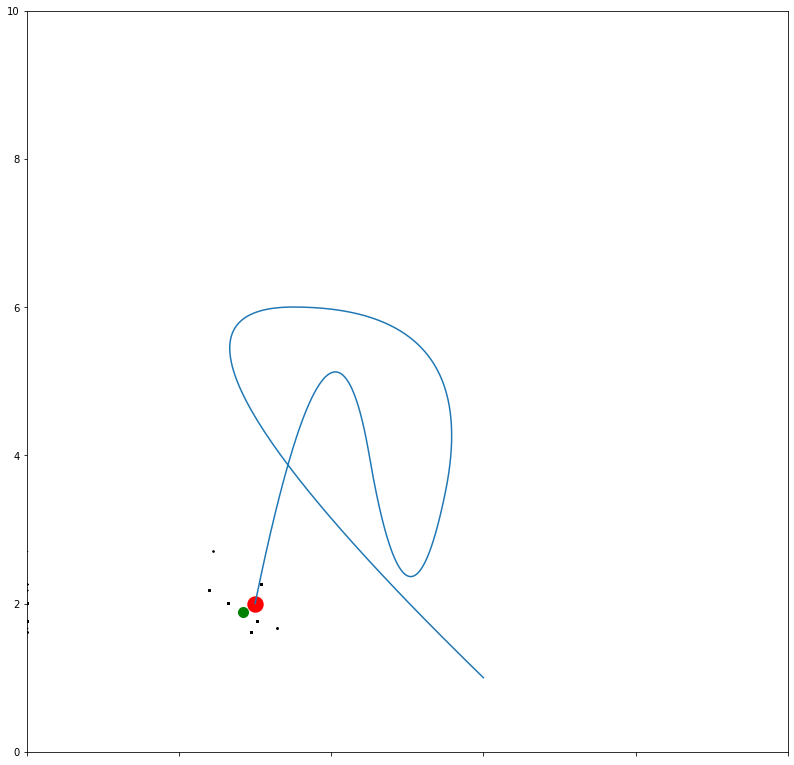

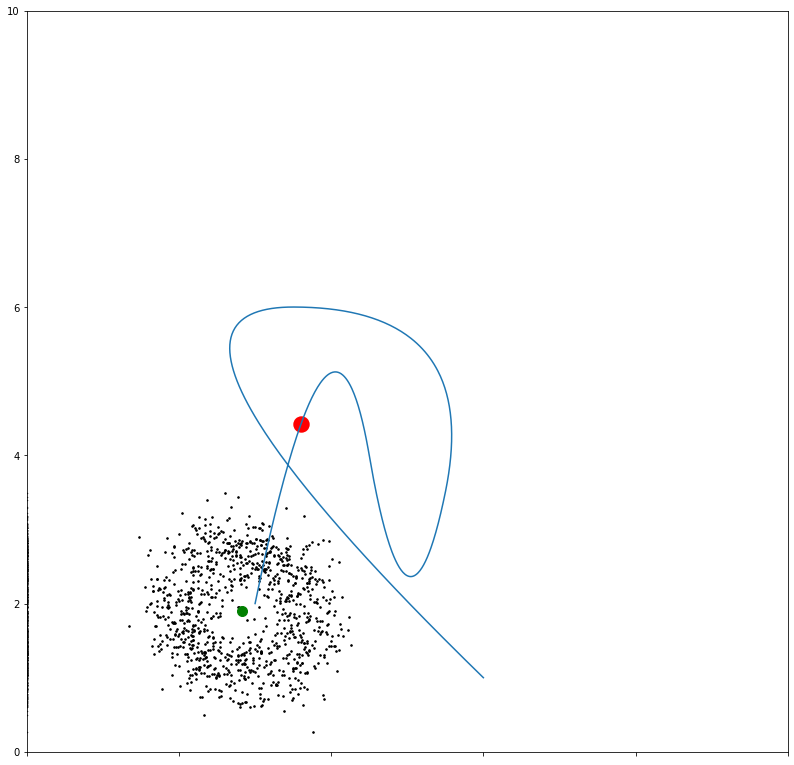

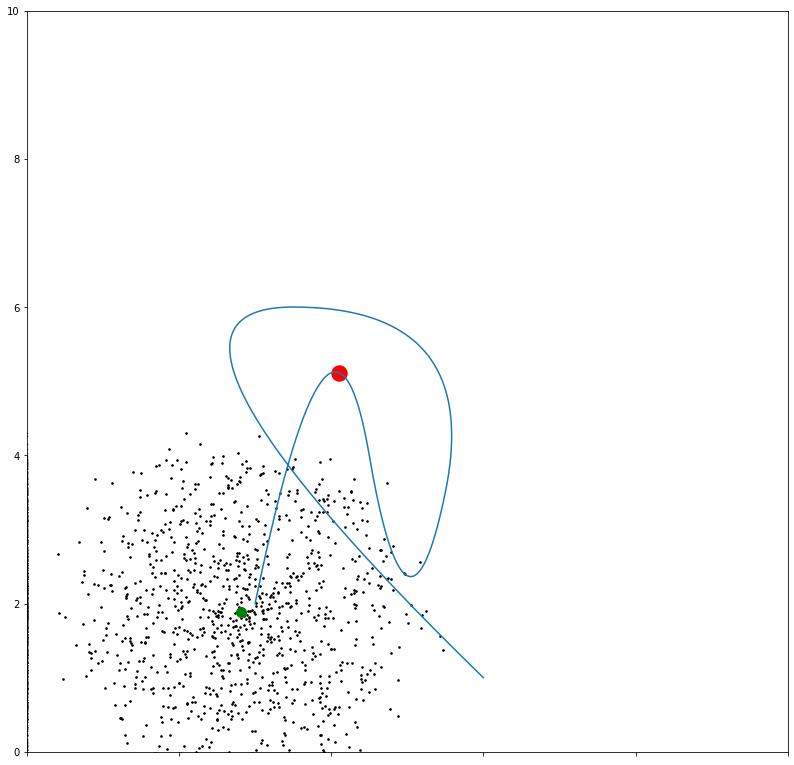

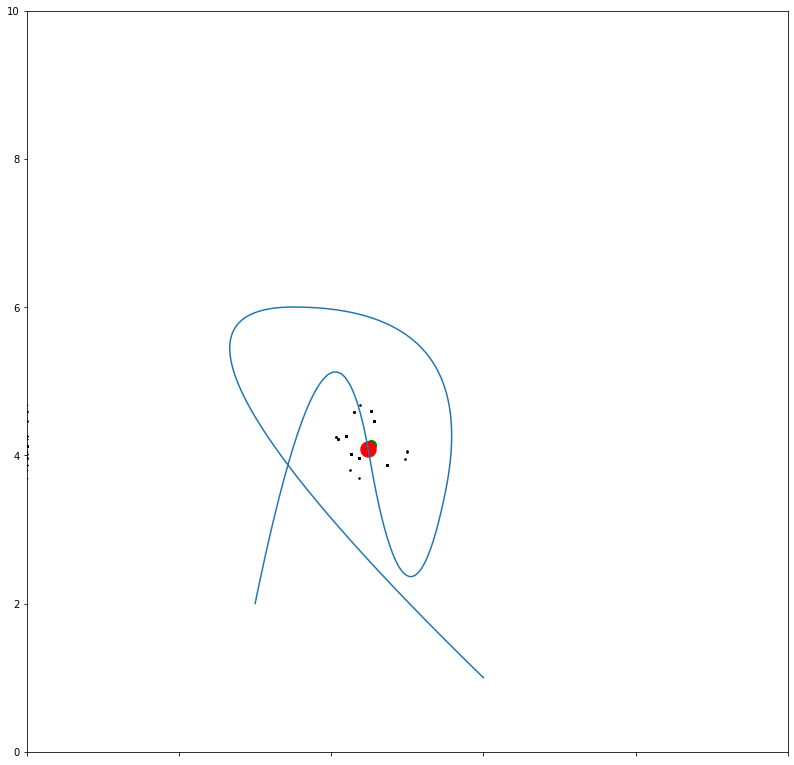

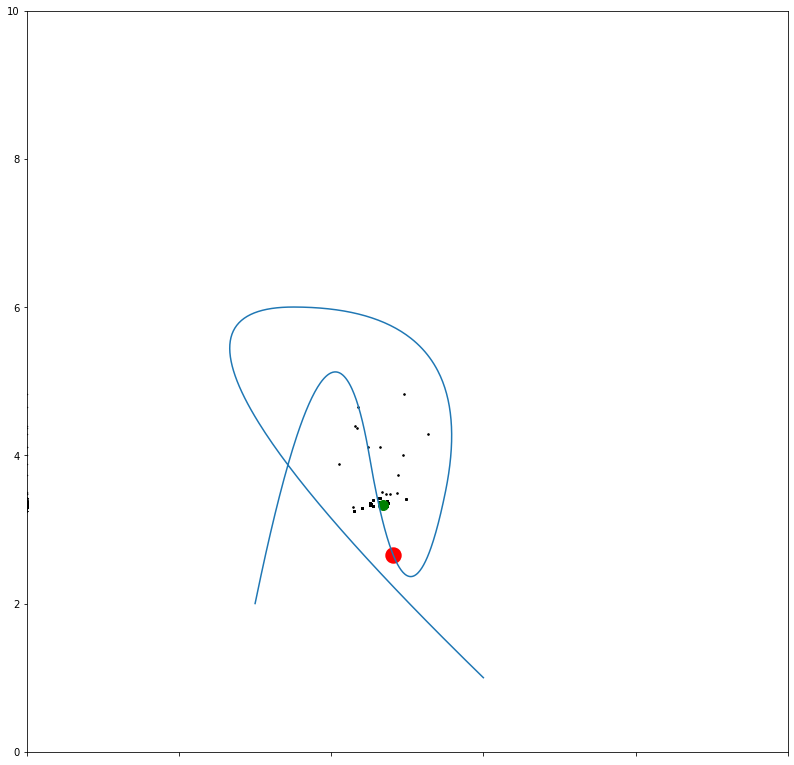

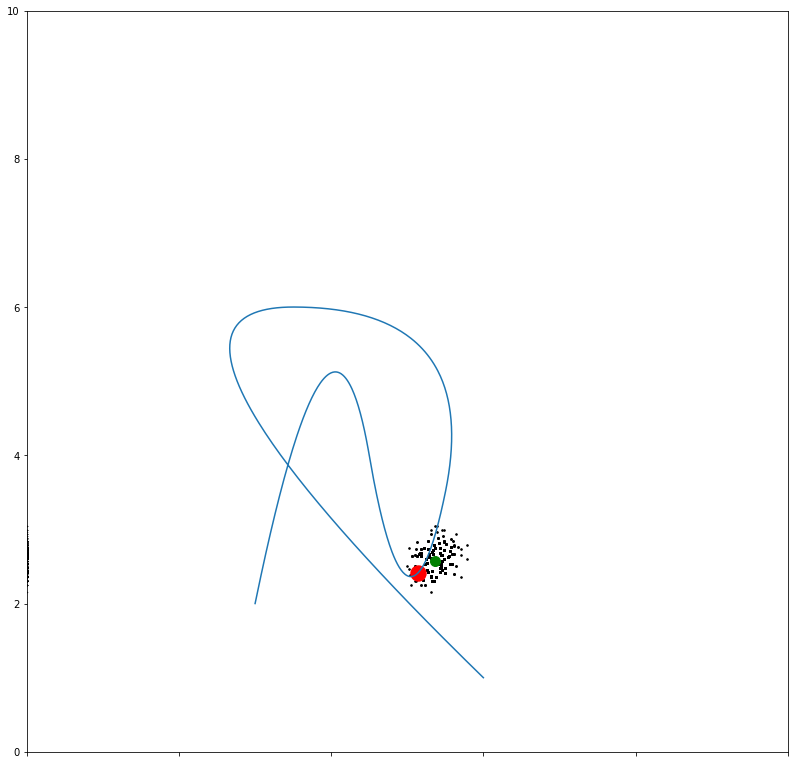

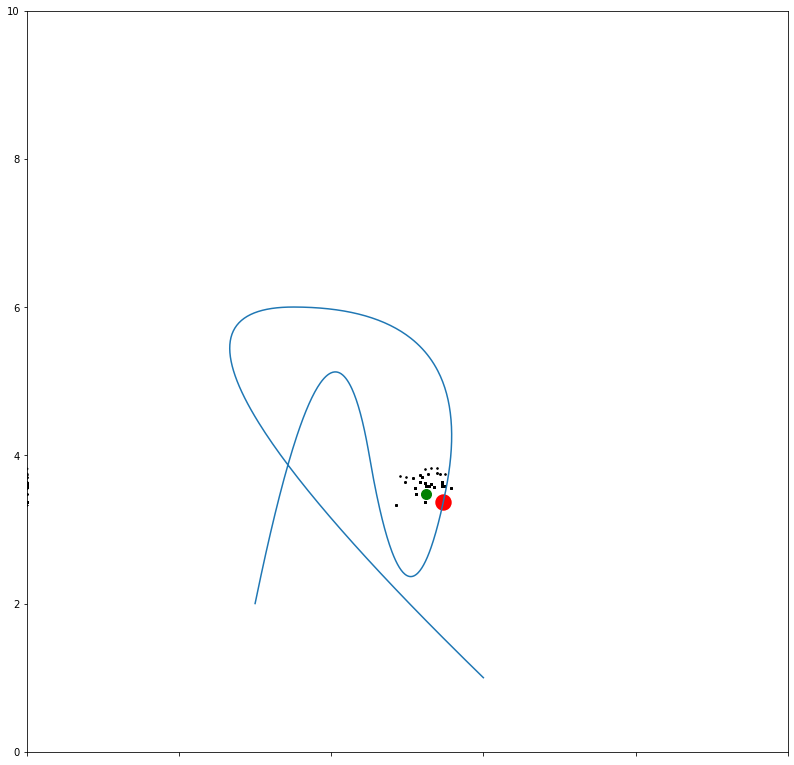

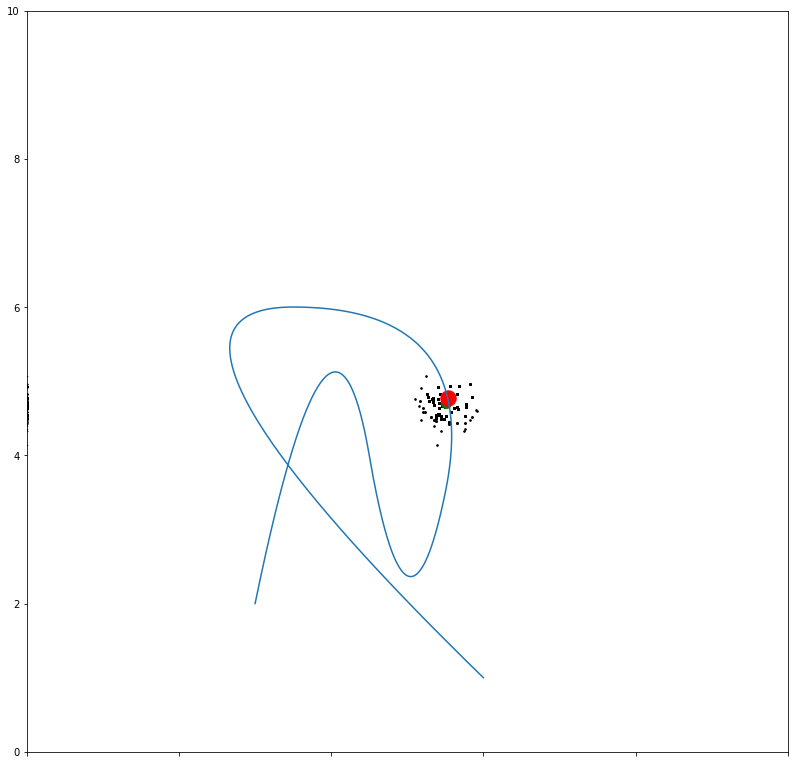

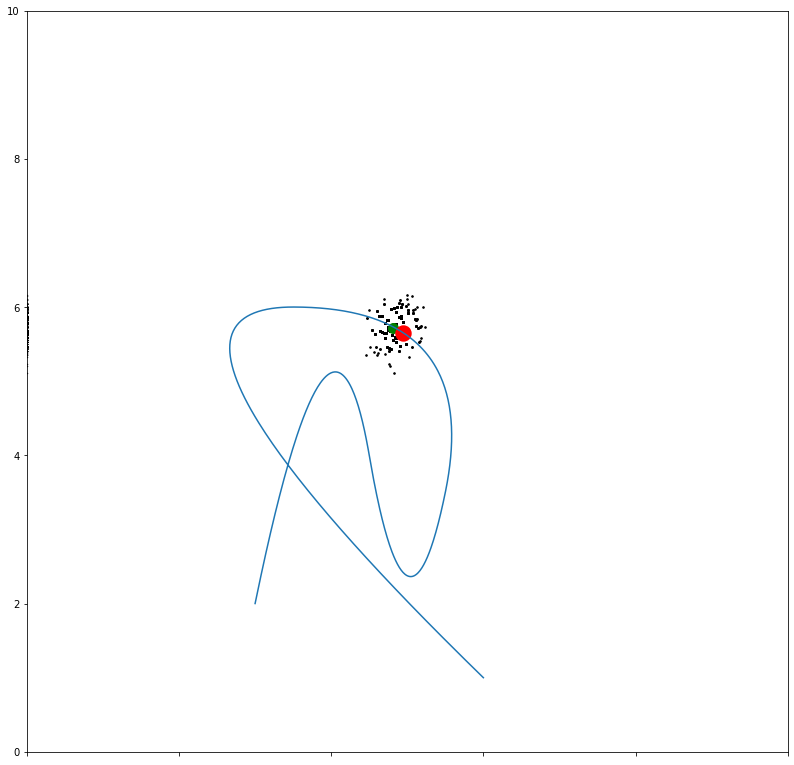

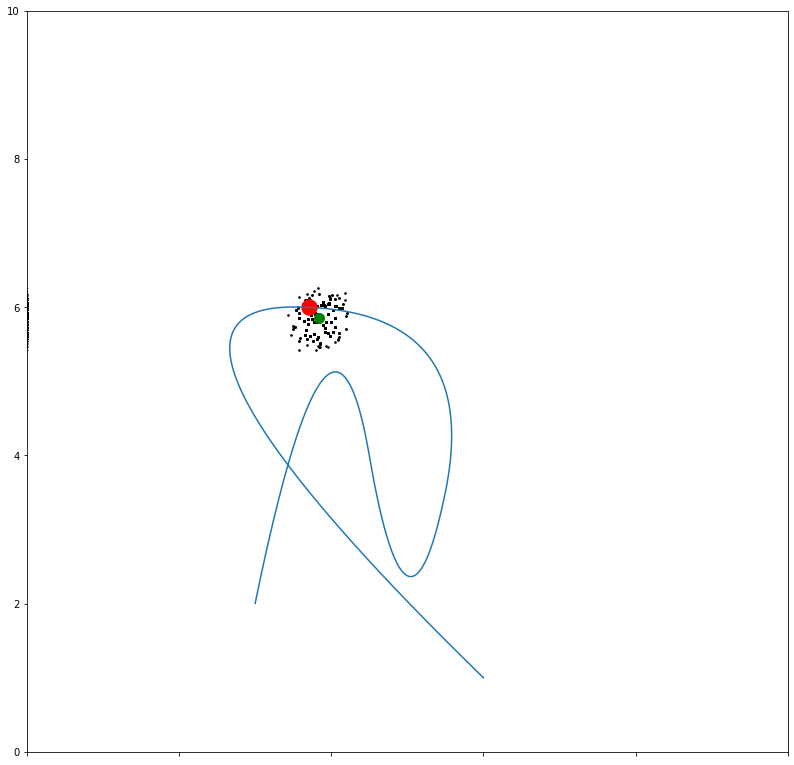

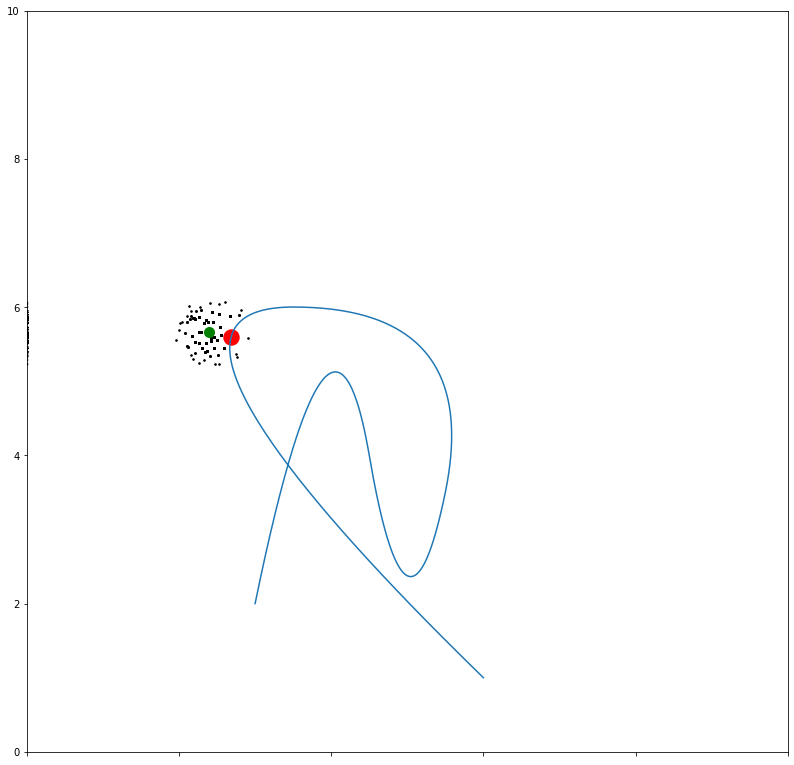

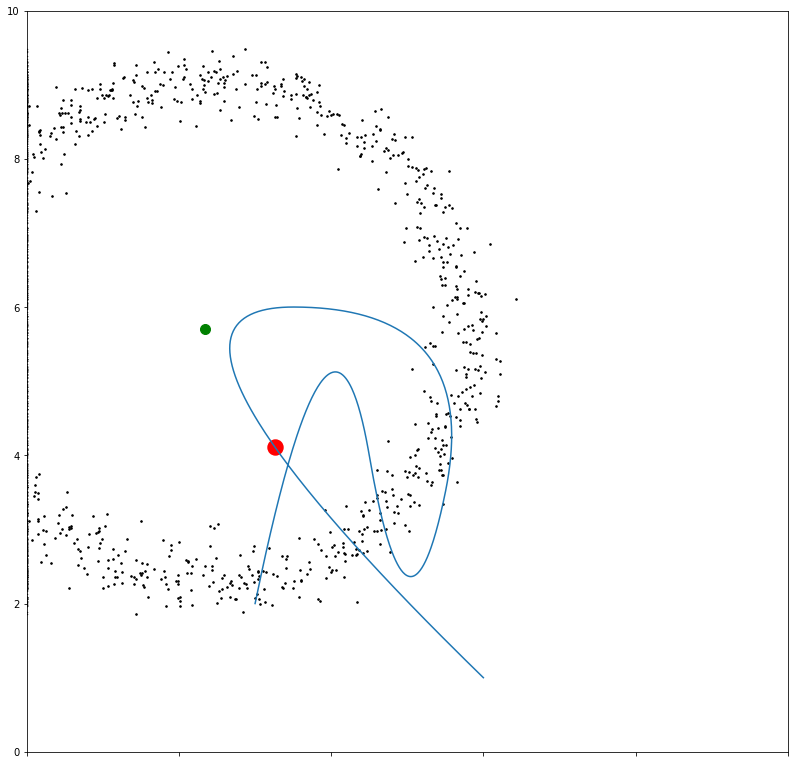

In [13]:
pf = ParticleFilter(N_p, size_x, size_y)
R = Robot(curve[0][0], curve[0][1], angle(curve[0], curve[1]))

waypoints = [curve[i] for i in range(0, 500, 500//iterations)]
indexes = [i for i in range(0, 500, 500//iterations)]

for i in range(iterations):
    plt.figure(figsize=(30,30))
    R.move_on_curve(curve, indexes[i])
    
    pf.predict1((dist(waypoints[i], waypoints[i+1]), angle(waypoints[i], waypoints[i+1])))
    pf.weight(R.get_dist_to_points())
    pf.resample()
    
    mean, var = pf.estimate()
    plot_pf(pf, 10, 10)
    plt.scatter(mean[0], mean[1], color='g', s=100)
    plt.scatter(R.x, R.y, color='r', s=180, lw=3)
    plt.plot(curve[:,0], curve[:,1])
    plt.show()